In [64]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


# Set all batch size

In [66]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

## Import data into tensorflow dataset object

In [68]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [70]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [72]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


## Visualize some of the images from our dataset

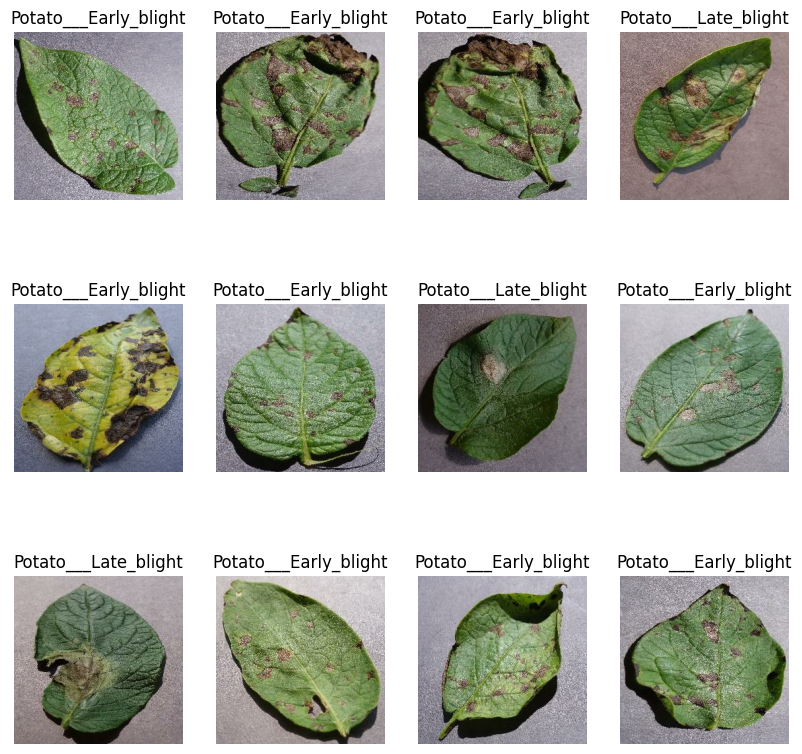

In [74]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [76]:
len(dataset)

68

In [78]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [80]:
train_ds = dataset.take(54)
len(train_ds)

54

In [82]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [84]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [86]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [88]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [92]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [94]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [96]:
len(train_ds)

54

In [98]:
len(val_ds)

6

In [100]:
len(test_ds)

8

# Cache, Shuffle, and Prefetch the Dataset

In [102]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

## Creating a Layer for Resizing and Normalization

In [104]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

## Data Augmentation

In [106]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

## Applying Data Augmentation to Train Dataset

In [108]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [110]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [112]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [114]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [116]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.4284 - loss: 0.9663 - val_accuracy: 0.5000 - val_loss: 0.8767
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.6128 - loss: 0.8297 - val_accuracy: 0.5208 - val_loss: 0.8259
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 380s 7s/step - accuracy: 0.7467 - loss: 0.5622 - val_accuracy: 0.8229 - val_loss: 0.4423
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.8440 - loss: 0.3961 - val_accuracy: 0.8125 - val_loss: 0.4556
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.8705 - loss: 0.3259 - val_accuracy: 0.8906 - val_loss: 0.2660
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8983 - loss: 0.2537 - val_accuracy: 0.7396 - val_loss: 0.6024
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9010 - loss: 0.2507 - val_accuracy: 0.9062 - val_loss: 0.2102
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9344 - loss: 0.1671 - val_accuracy: 0.8125 - va

In [118]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 853ms/step - accuracy: 0.9701 - loss: 0.1198


You can see above that we get 90.00% accuracy for our test dataset. This is considered to be a pretty good accuracy

In [120]:
scores

[0.1271427720785141, 0.96875]

Scores is just a list containing loss and accuracy value

Plotting the Accuracy and Loss Curves

In [124]:
history

In [126]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [128]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [131]:
type(history.history['loss'])

list

In [133]:
len(history.history['loss'])

10

In [135]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9166970252990723,
 0.7770581245422363,
 0.5123341083526611,
 0.4058431088924408,
 0.3092624843120575]

In [139]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

10 10 10 10


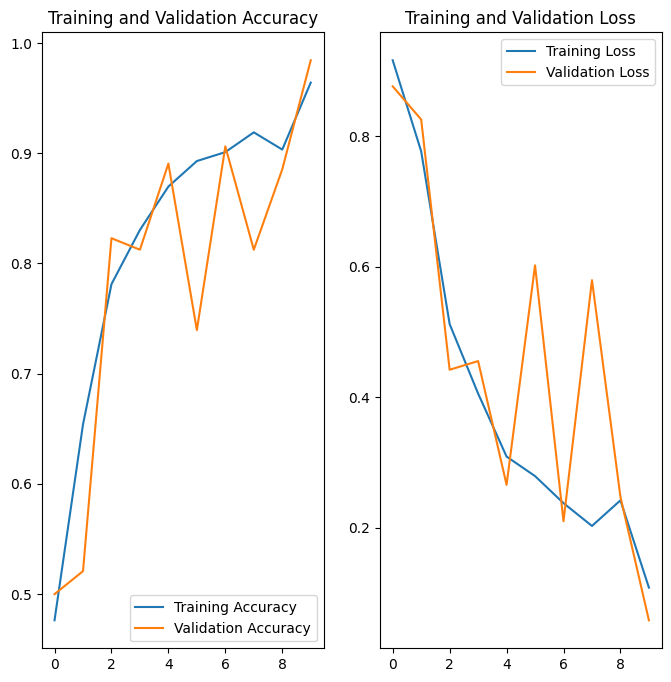

In [141]:
# Set the number of epochs
EPOCHS = 10  # Your epoch size

# Ensure acc, val_acc, loss, val_loss have 10 values each
print(len(acc), len(val_acc), len(loss), len(val_loss))

assert len(acc) == EPOCHS, "acc should have EPOCHS elements"
assert len(val_acc) == EPOCHS, "val_acc should have EPOCHS elements"
assert len(loss) == EPOCHS, "loss should have EPOCHS elements"
assert len(val_loss) == EPOCHS, "val_loss should have EPOCHS elements"

# Plotting
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted label: Potato___Early_blight


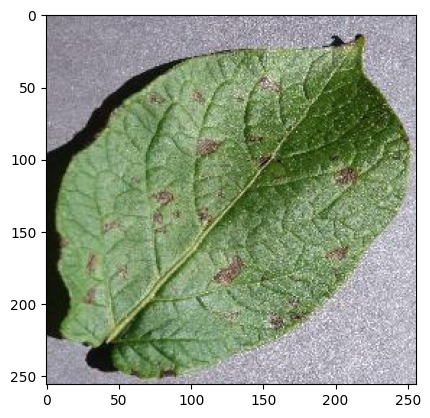

In [144]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [147]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


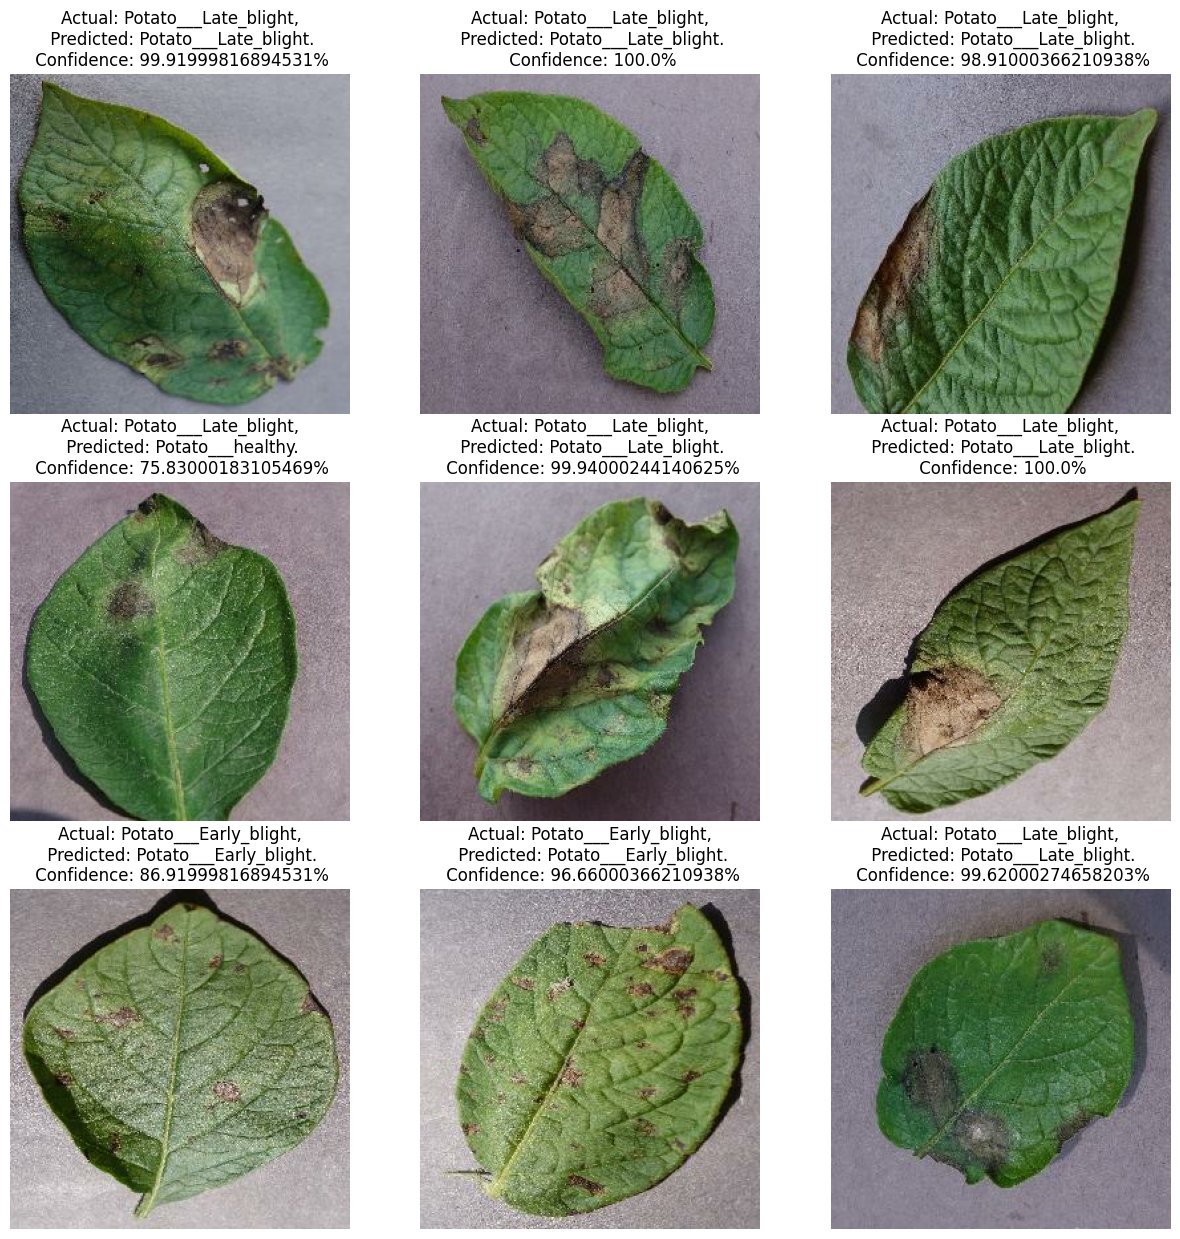

In [150]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the Model

In [153]:
'''import os

# Find the next version number
model_version = max([int(i) for i in os.listdir("../models") if i.isdigit()] + [0]) + 1

# Save the model with a valid file extension (e.g., .h5)
model.save(f"../models/{model_version}.keras")'''

'import os\n\n# Find the next version number\nmodel_version = max([int(i) for i in os.listdir("../models") if i.isdigit()] + [0]) + 1\n\n# Save the model with a valid file extension (e.g., .h5)\nmodel.save(f"../models/{model_version}.keras")'

In [173]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}.keras")

ValueError: invalid literal for int() with base 10: '1.keras'

In [171]:
# Export the model for TensorFlow Serving or TFLite
model.export(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/1\assets


INFO:tensorflow:Assets written to: ../saved_models/1\assets


Saved artifact at '../saved_models/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_26')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1285307005264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307239232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307241168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307236944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307242752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307237296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307243632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307242048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307245216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307240288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307246800: TensorSpec(shap

In [177]:
model_version = 2
model.save(f"../saved_models/{model_version}.keras")

In [179]:
model.export(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/2\assets


INFO:tensorflow:Assets written to: ../saved_models/2\assets


Saved artifact at '../saved_models/2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_26')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1285307005264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307239232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307241168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307236944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307242752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307237296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307243632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307242048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307245216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307240288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1285307246800: TensorSpec(shap